In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# Constants
DATA_PATH = "labeled_video"
IMG_SIZE = 224
FRAMES_PER_VIDEO = 15
FINE_TUNE_LAYERS = 50
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 15

In [3]:
# Frame extraction
def extract_frames_from_videos(data_path, frames_per_video=5):
    X, y = [], []
    labels = os.listdir(data_path)

    for label in labels:
        folder_path = os.path.join(data_path, label)
        if not os.path.isdir(folder_path):
            continue
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
            if not file.endswith(".mp4"):
                continue
            video_path = os.path.join(folder_path, file)
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            interval = max(1, frame_count // frames_per_video)

            for i in range(frames_per_video):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                    X.append(frame)
                    y.append(label)

            cap.release()
    return np.array(X), np.array(y)

In [4]:
# Load data
X, y = extract_frames_from_videos(DATA_PATH, FRAMES_PER_VIDEO)
X = X / 255.0
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)
NUM_CLASSES = y_cat.shape[1]

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Labels:", le.classes_)

Processing thin: 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Training samples: 1416
Validation samples: 354
Labels: ['bed' 'before' 'candy' 'cool' 'drink' 'go' 'help' 'thin']


In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [6]:
# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze for initial training

In [7]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

In [9]:
# Initial training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

C:\Users\joshu\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.2117 - loss: 2.1133
Epoch 1: val_accuracy improved from -inf to 0.45480, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - accuracy: 0.2132 - loss: 2.1095 - val_accuracy: 0.4548 - val_loss: 1.5693 - learning_rate: 0.0010
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.4730 - loss: 1.4798
Epoch 2: val_accuracy improved from 0.45480 to 0.57062, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.4734 - loss: 1.4788 - val_accuracy: 0.5706 - val_loss: 1.2726 - learning_rate: 0.0010
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5544 - loss: 1.2222
Epoch 3: val_accuracy improved from 0.57062 to 0.63842, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.5547 - loss: 1.2214 - val_accuracy: 0.6384 - val_loss: 1.0427 - learning_rate: 0.0010
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step 

In [10]:
# Unfreeze last N layers for fine-tuning
for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Fine-tune training
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5588 - loss: 1.5547
Epoch 1: val_accuracy did not improve from 0.88418
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.5604 - loss: 1.5456 - val_accuracy: 0.7147 - val_loss: 0.7733 - learning_rate: 1.0000e-04
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7592 - loss: 0.6773
Epoch 2: val_accuracy did not improve from 0.88418
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.7606 - loss: 0.6740 - val_accuracy: 0.7599 - val_loss: 0.8227 - learning_rate: 1.0000e-04
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8667 - loss: 0.3861
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 3: val_accuracy did not improve from 0.88418
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - accuracy: 0.8665 - loss: 0.3866 - val_accuracy: 0.7203 - val_loss: 0.9572 - learning_rate: 1.0000e-04


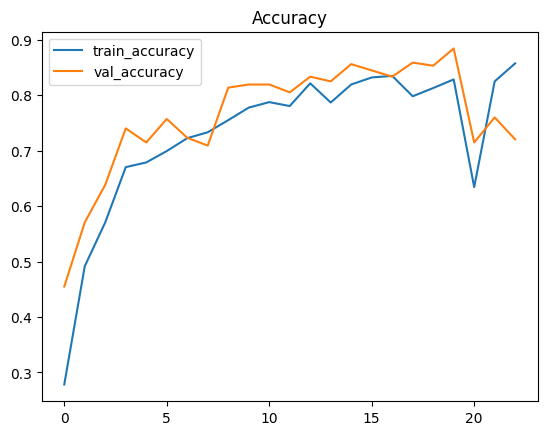

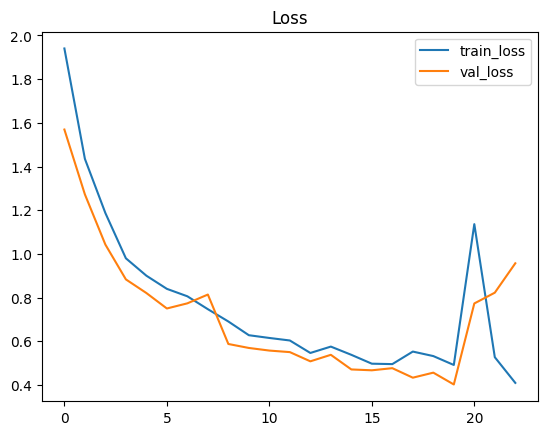

In [12]:
# Plot results
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


In [13]:
# Save model
model.save("asl_mobilenetv2_finetuned.h5")
print("✅ Model saved as 'asl_mobilenetv2_finetuned.h5'")

✅ Model saved as 'asl_mobilenetv2_finetuned.h5'
